In [3]:
"""
Analysis pipeline on BERT models

BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
https://arxiv.org/abs/1810.04805

BERT is multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017)
"""

import numpy as np
import matplotlib.pyplot as plt

from transformers import BertModel

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
'import BERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 12
d = 768
h = 12

model = BertModel.from_pretrained("bert-base-uncased")

In [5]:
"""
get Wq and Wk matrices and compute the pseudo-quadratic-form M = Wq@Wk^T
returns:
- Wq (list): query projection matrix for each layer
- Wk (list): key projection matrix for each layer
- Wv (list): value projection matrix for each layer
- M (list): inner product matrix for each layer
"""

def get_matrices(model):

    layers = len(model.encoder.layer)    
    Wq, Wk, Wv, M = [], [], [], []
    for l in range(layers):
        Wq.append(model.encoder.layer[l].attention.self.query.weight.detach().numpy())
        Wk.append(model.encoder.layer[l].attention.self.key.weight.detach().numpy())
        Wv.append(model.encoder.layer[l].attention.self.value.weight.detach().numpy())
        M.append(Wq[l]@(Wk[l].T))        

    return Wq, Wk, Wv, M

Wq, Wk, Wv, M = get_matrices(model)

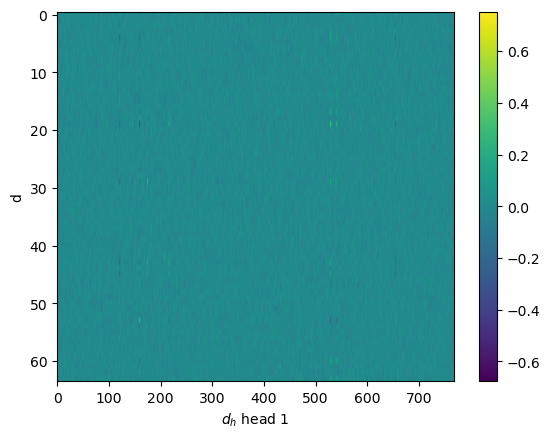

In [6]:
"""
Each attention layer has a = 12 heads. Effectively, each projection matrix Wq, Wk, and Wv 
is divided into 12 sub-matrices of dimension d/h x d/
"""

dh = d // h

plt.imshow(Wk[0][:dh,:],aspect='auto')
plt.ylabel('d')
plt.xlabel(r'$d_h$ head 1')
plt.colorbar()

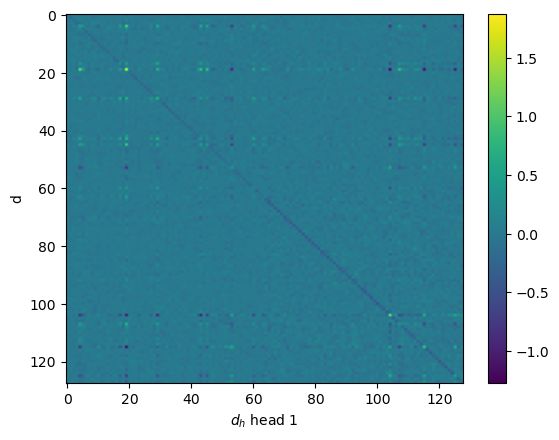

In [7]:
"""
We define the pseudo-quadratic form M = Wq@Wk^T. Given that attention is divided into heads, 
we expect this matrix to be a block matrix, with h*h blocks of dimensions d/h x d/h.
"""
plt.imshow(M[0][:2*dh,:2*dh],aspect='auto') ## show first 4 blocks of matrix M in the first layer
plt.ylabel('d')
plt.xlabel(r'$d_h$ head 1')
plt.colorbar()

In [8]:
"""
Hypothesis 2: the diagonal block of the matrix M are low-rank and with few eigenvalues 
outside of the unit cycle.

We calculate the eigenvalues for each diagonal block, we check how many eigenvalues are outside
of the unit circle, how this differs across heads, and if behaviour is conserved in the whole matrix.

()
"""

def eigen_(A):
    eigenvalues = np.linalg.eigvals(A)
    abs_values = np.absolute(eigenvalues)
    return eigenvalues, abs_values

layer = 4
eigenvalues, abs_values = eigen_(M[layer])

Text(0, 0.5, 'abs value')

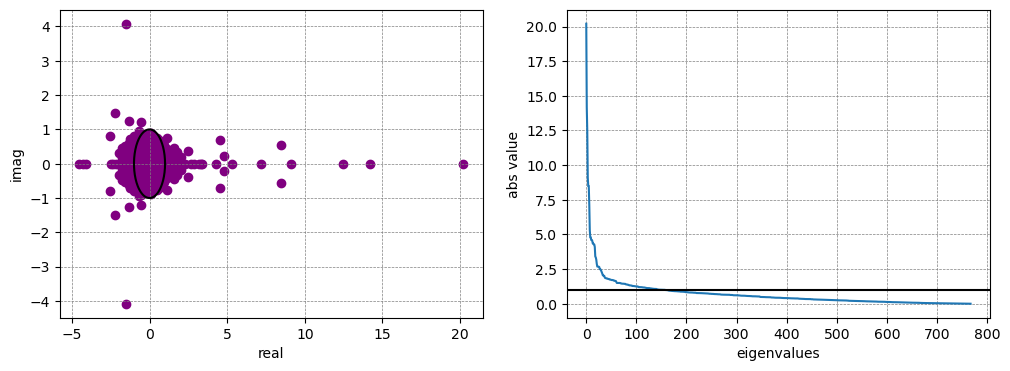

In [9]:
angle = np.linspace(0, 2*np.pi, 200)
x = np.cos(angle)
y = np.sin(angle)

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'k') 
plt.scatter(eigenvalues.real,eigenvalues.imag,color='purple')
plt.xlabel('real')
plt.ylabel('imag')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.plot(np.sort(abs_values)[::-1])
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.axhline(y=1,color='k')
plt.xlabel('eigenvalues')
plt.ylabel('abs value')

In [10]:
def decomposition_syn_asyn(A):
    
    asyn_part = np.linalg.norm(.5 * (A - A.T), 'fro') / np.linalg.norm(A, 'fro')
    syn_part = np.linalg.norm(.5 * (A + A.T), 'fro') / np.linalg.norm(A, 'fro')

    return syn_part, asyn_part

def decomposition_layers(l,A):
    scoresyn = np.zeros(l)
    scoreasyn = np.zeros(l)
    for idx, layer in enumerate(range(l)):
        scoresyn[idx], scoreasyn[idx] = decomposition_syn_asyn(A[layer])
    return scoresyn, scoreasyn

S_score, N_score = decomposition_layers(l,M)

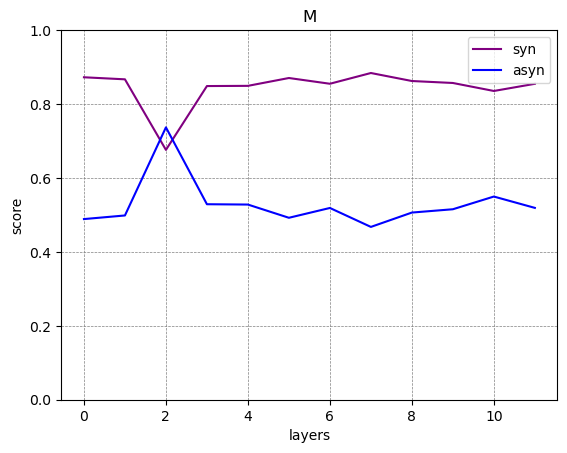

In [11]:
plt.title('M')
plt.plot(S_score,color='purple',label='syn')
plt.plot(N_score,color='blue',label='asyn')
plt.xlabel('layers')
plt.ylabel('score')
plt.ylim(0,1)
plt.legend()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

In [49]:
"""
eigenvalues distribution across the network layers

We quantify how the percentage of leading eigenvalues (with magnitude > 1) changes across layers,
and how many eigenvalues are either real or complex conjugates
"""

lead_eigen = np.zeros(l)
lead_eigen_real = np.zeros(l)
lead_eigen_imag = np.zeros(l)

for layer in range(l):
    eigenvalues, abs_values = eigen_(M[layer])    
    lead_eigen[layer] = np.sum(abs_values > 1)
    eigen = eigenvalues[abs_values > 1]
    lead_eigen_real[layer] = np.sum(eigen.imag == 0)
    lead_eigen_imag[layer] = np.sum(eigen.imag != 0)

lead_eigen = lead_eigen/d

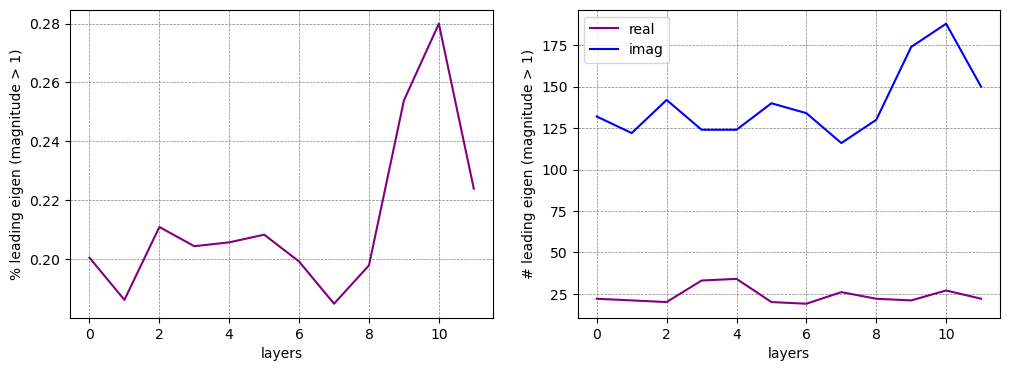

In [50]:
'plots'
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(lead_eigen,c='purple')
plt.xlabel('layers')
plt.ylabel('% leading eigen (magnitude > 1)')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.plot(lead_eigen_real,c='purple',label='real')
plt.plot(lead_eigen_imag,c='blue',label='imag')
plt.xlabel('layers')
plt.ylabel('# leading eigen (magnitude > 1)')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()